In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes, mark_sentence

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
def tag_sentence(x):
    candidates=(
        session
        .query(DiseaseGene)
        .filter(DiseaseGene.id.in_(x.candidate_id.astype(int).tolist()))
        .all()
    )
    tagged_sen=[
         " ".join(
             mark_sentence(
                candidate_to_tokens(cand), 
                [
                        (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                        (cand[1].get_word_start(), cand[1].get_word_end(), 2)
                ]
            )
         )
        for cand in candidates
    ]

    return tagged_sen

In [6]:
spreadsheet_names = {
    'train': '../data/sentences/sentence_labels_train.xlsx',
    'dev': '../data/sentences/sentence_labels_dev.xlsx',
    'test': '../data/sentences/sentence_labels_test.xlsx'
}

In [7]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_dsh")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of train set: 300
Size of dev set: 1000
Size of test set: 1000


In [8]:
dev_predictions_df = pd.read_table("results/before_100_sampled_lfs.tsv_dev.tsv")
dev_predictions_df.columns = ["model_predictions", "candidate_id"]
dev_predictions_df.head(2)

,model_predictions,candidate_id
0,0.829591,21841
1,0.704084,82680


In [9]:
model_predictions_df = (
    candidate_dfs['dev']
    .merge(dev_predictions_df)
    [["curated_dsh", "model_predictions", "candidate_id"]]
    .round(2)
)
model_predictions_df.head(2)

,curated_dsh,model_predictions,candidate_id
0,1.0,0.83,21841
1,0.0,0.70,82680


In [10]:
dev_all_predictions_df = pd.read_table("results/after_100_sampled_lfs.tsv_dev.tsv")
dev_all_predictions_df.columns = ["candidate_id", "model_predictions_after"]
dev_all_predictions_df.head(2)

,candidate_id,model_predictions_after
0,21841,0.581059
1,82680,0.544670


In [11]:
total_candidates_df = pd.read_csv("../dataset_statistics/results/all_dag_map.tsv.xz", sep="\t")
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,0.0,1.0,3.0,2129459,The number of H antigen sites per single red c...,172,176680
1,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,0.0,1.0,3.0,2129459,The number of H antigen sites per single red c...,172,176675


In [12]:
confidence_score_df = (
    total_candidates_df
    [["doid_name", "gene_symbol", "text", "candidate_id"]]
    .merge(dev_predictions_df, on="candidate_id")
    .merge(dev_all_predictions_df, on="candidate_id")
    .sort_values("candidate_id")
    .assign(text=lambda x: tag_sentence(x))
    .sort_values("model_predictions_after")
)
confidence_score_df.head(2)

,doid_name,gene_symbol,text,candidate_id,model_predictions,model_predictions_after
115,hematologic cancer,C7,serum antibody responses to four haemophilus i...,908730,0.001527,0.207535
607,hepatitis B,PKD2,"conversely , a significant enhancement of acti...",2027448,0.002017,0.217155


In [13]:
(
    confidence_score_df
    .head(10)
    .sort_values("model_predictions_after", ascending=False)
    .drop("candidate_id", axis=1)
    .round(3)
    .to_csv("results/bottom_ten_high_confidence_scores.tsv", sep="\t", index=False)
)

In [14]:
(
    confidence_score_df
    .tail(10)
    .sort_values("model_predictions_after", ascending=False)
    .drop("candidate_id", axis=1)
    .round(3)
    .to_csv("results/top_ten_high_confidence_scores.tsv", sep="\t", index=False)
)

In [15]:
model_all_predictions_df = (
    candidate_dfs['dev']
    .merge(dev_all_predictions_df.rename(index=str, columns={"model_predictions_after":"model_predictions"}))
    [["curated_dsh", "model_predictions"]]
    .round(2)
)
model_all_predictions_df.head(2)

,curated_dsh,model_predictions
0,1.0,0.58
1,0.0,0.54


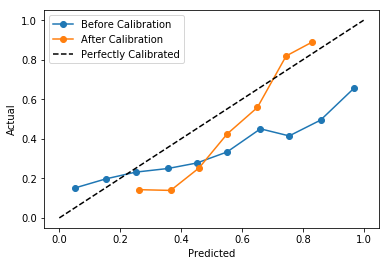

In [16]:
from sklearn.calibration import calibration_curve
cnn_y, cnn_x = calibration_curve(model_predictions_df.curated_dsh, model_predictions_df.model_predictions, n_bins=10)
all_cnn_y, all_cnn_x = calibration_curve(model_predictions_df.curated_dsh, model_all_predictions_df.model_predictions, n_bins=10)

plt.plot(cnn_x, cnn_y, marker='o', label="Before Calibration")
plt.plot(all_cnn_x, all_cnn_y, marker='o', label="After Calibration")
plt.plot([0,1], [0,1], color='black', linestyle='--', label="Perfectly Calibrated")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.legend()